In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import matplotlib.pyplot as plt
import seaborn as sns

import os


import tensorflow as tf
import keras
from keras_retinanet.models import mobilenet, convert_model
from keras_retinanet import losses
from keras_retinanet.utils.eval import evaluate
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

Using TensorFlow backend.


In [2]:
#Debug script. This gave us good results. the debug script tells us that none of the obj are too small to be identified. Good anchors in FPN.
#python C:\Users\willg\AppData\Local\Programs\Python\Python36\Lib\site-packages\keras-retinanet-master\keras_retinanet\bin\debug.py --l --annotations csv C:\Users\willg\Wellth_Challenge\train.csv C:\Users\Willg\blood\classes.csv

In [3]:
train_df = pd.read_csv('training_annotations.csv')

In [4]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,coins00000109.jpg,800,533,other,158,192,305,328
1,lunODHd9HhRTTj8jrK79WjYvIYgK5N2k_pill.jpg,500,500,pill,78,42,144,208
2,bottlecaps00000271.jpg,898,1300,other,207,627,707,1074
3,ml576nXYA1vvGg0FTl7Khy3hinY2xfOf_pill.jpg,1500,1500,pill,446,863,663,1088
4,lJ6t4CTHMogiFp0DvbtUYhDlHh3cAWLH_pill.jpg,1500,1500,pill,516,567,682,901


In [5]:
train = train_df.drop(['width', 'height'], axis=1)
train.head()

,filename,class,xmin,ymin,xmax,ymax
0,coins00000109.jpg,other,158,192,305,328
1,lunODHd9HhRTTj8jrK79WjYvIYgK5N2k_pill.jpg,pill,78,42,144,208
2,bottlecaps00000271.jpg,other,207,627,707,1074
3,ml576nXYA1vvGg0FTl7Khy3hinY2xfOf_pill.jpg,pill,446,863,663,1088
4,lJ6t4CTHMogiFp0DvbtUYhDlHh3cAWLH_pill.jpg,pill,516,567,682,901


In [6]:
#Listing images with invalid annotations
for index, row in train.iterrows():
    if row['xmin'] >= row['xmax']:
        print(index, row)
    if row['ymin'] >= row['ymax']:
        print(index, row)

107 filename    Nv2rSNtWire4EbjW2nyHfL4rkzaCbFuK_pill.jpg
class                                            pill
xmin                                              222
ymin                                              408
xmax                                              222
ymax                                              408
Name: 107, dtype: object
107 filename    Nv2rSNtWire4EbjW2nyHfL4rkzaCbFuK_pill.jpg
class                                            pill
xmin                                              222
ymin                                              408
xmax                                              222
ymax                                              408
Name: 107, dtype: object
718 filename    nvPPwU6RTJwCg04hGFbPABsm6iyLqL2h_pill.jpg
class                                            pill
xmin                                              297
ymin                                              358
xmax                                              297
ymax                

In [7]:
#Adjusting column order for Retinanet
train = train[['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class']]

# dropping these training examples that have lines instead of boxes for annotations
train.drop([107, 718, 1128], axis=0, inplace=True)

#Adding training_images sub folder to file name
cwd = os.getcwd()
for idx, row in train.iterrows():
    name = cwd + '\\training_images\\' + row.filename
    train.at[idx, 'filename'] = name
 
#roughly 80/20 split by num of objects
train.reset_index(drop=True, inplace=True)
test = train.iloc[1150:]
train = train.iloc[:1150]
    
test.to_csv('test.csv', index = False, header = False)
train.to_csv('train.csv', index = False, header = False)

In [8]:
train.shape

(1150, 6)

In [9]:
test.shape

(277, 6)

In [10]:
train.tail()

,filename,xmin,ymin,xmax,ymax,class
1145,C:\Users\willg\Wellth_Challenge\training_images\MWmFHG6bYgY8Lu9LqEUUUHiR8seLffUg_pill.jpg,271,404,339,454,pill
1146,C:\Users\willg\Wellth_Challenge\training_images\bottlecaps00000252.jpg,224,87,292,110,other
1147,C:\Users\willg\Wellth_Challenge\training_images\bottlecaps00000252.jpg,232,138,296,232,other
1148,C:\Users\willg\Wellth_Challenge\training_images\bottlecaps00000252.jpg,148,186,211,247,other
1149,C:\Users\willg\Wellth_Challenge\training_images\bottlecaps00000252.jpg,85,224,142,249,other


In [11]:
test.head()

,filename,xmin,ymin,xmax,ymax,class
1150,C:\Users\willg\Wellth_Challenge\training_images\coins00000129.jpg,338,418,617,596,other
1151,C:\Users\willg\Wellth_Challenge\training_images\coins00000129.jpg,333,6,650,233,other
1152,C:\Users\willg\Wellth_Challenge\training_images\M74AYBgX35QpocJZoH2nznbCy2u6siFd_pill.jpg,120,149,288,198,pill
1153,C:\Users\willg\Wellth_Challenge\training_images\M74AYBgX35QpocJZoH2nznbCy2u6siFd_pill.jpg,219,105,443,173,pill
1154,C:\Users\willg\Wellth_Challenge\training_images\MTSgDxKYwhOpLFnUrKeJ2YKurEcBr3aj_pill.jpg,204,258,368,349,pill


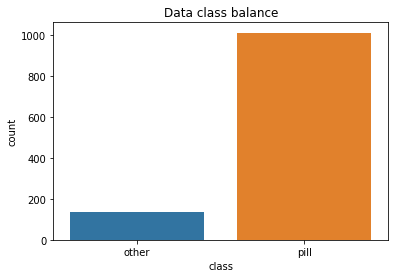

Class Counts:
pill     1012
other     138
Name: class, dtype: int64

Class Percent:
88.0
12.0


In [12]:
#plot
plt.title('Data class balance')
sns.countplot(x="class", data=train, order=['other', 'pill'])
plt.show()

#stats
class_count = train['class'].value_counts()
print('Class Counts:')
print(class_count)
#Class percent
print('\nClass Percent:')
for x in class_count:
    print(round(x / train.shape[0], 5)*100)
    

In [13]:
train_gen = CSVGenerator(csv_data_file = 'train.csv', csv_class_file = 'classes.csv')
test_gen = CSVGenerator(csv_data_file = 'test.csv', csv_class_file = 'classes.csv')

print(train_gen.size(), test_gen.size())

444 101


In [14]:
num_epochs = 3
steps_per_epoch = 545
lr = 1e-5

model = mobilenet.MobileNetBackbone('mobilenet224_1.0').retinanet(num_classes=2)
#download weights
#weights_path = mobilenet.MobileNetBackbone('mobilenet224_1.0').download_imagenet()
weights_path = r'C:\Users\willg\.keras\models\mobilenet_1_0_224_tf_no_top.h5'
model.load_weights(weights_path, by_name=True, skip_mismatch=True)

In [15]:
model.compile(
    loss={
        'regression'    : losses.smooth_l1(),
        'classification': losses.focal()
    },
    optimizer=keras.optimizers.adam(lr=lr, clipnorm=0.001)
)


In [16]:
result = model.fit_generator(
            train_gen,
            steps_per_epoch = 1150,
            epochs=num_epochs,
            verbose = 1,
            class_weight= {0:0.88, 1:0.12},
            validation_data = test_gen,
            validation_steps=270
)

Epoch 1/3
1150/1150 [==============================] - 168s 146ms/step - loss: 3.5178 - regression_loss: 2.6295 - classification_loss: 0.8883 - val_loss: 3.7192 - val_regression_loss: 2.5398 - val_classification_loss: 1.1794
Epoch 2/3
1150/1150 [==============================] - 143s 124ms/step - loss: 2.7523 - regression_loss: 2.0677 - classification_loss: 0.6846 - val_loss: 3.3630 - val_regression_loss: 2.2089 - val_classification_loss: 1.1541
Epoch 3/3
1150/1150 [==============================] - 143s 124ms/step - loss: 2.1882 - regression_loss: 1.6031 - classification_loss: 0.5851 - val_loss: 3.1893 - val_regression_loss: 2.1339 - val_classification_loss: 1.0554


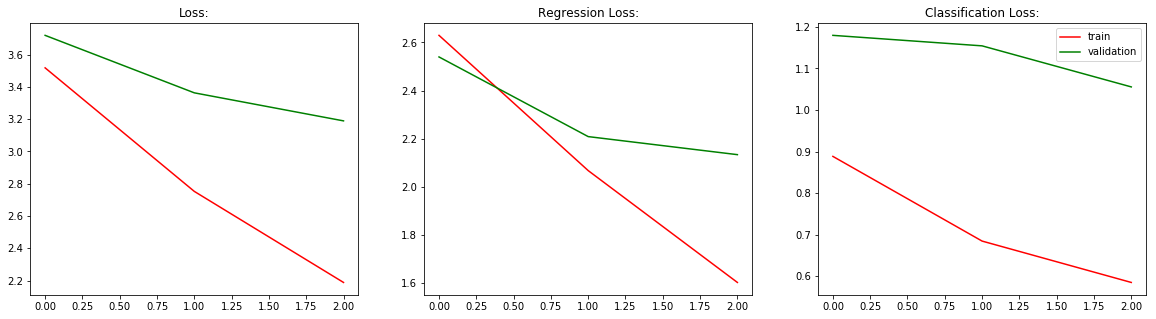

In [17]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title('Loss:')
plt.plot(result.history['loss'],'r')
plt.plot(result.history['val_loss'],'g')

plt.subplot(1, 3, 2)
plt.title('Regression Loss:')
plt.plot(result.history['regression_loss'],'r')
plt.plot(result.history['val_regression_loss'],'g')

plt.subplot(1, 3, 3)
plt.title('Classification Loss:')
plt.plot(result.history['classification_loss'],'r')
plt.plot(result.history['val_classification_loss'],'g')
plt.legend(['train','validation'])

plt.show()

In [18]:
model = convert_model(model)
evaluate(train_gen, model)

Running network: 100% (444 of 444) |#####| Elapsed Time: 0:00:35 Time:  0:00:35
Parsing annotations: 100% (444 of 444) |#| Elapsed Time: 0:00:00 Time:  0:00:00


{0: (0.004573815293162111, 138.0), 1: (0.3808006291915541, 1012.0)}

This Cell computes our average precision for each class. The background class "other" has no recognizable patterns so it scores really low 0.4%, and our pill class scores 38% average precision.

In [19]:
#model.save('RetinaNet_mobilenet224.h5')